In [18]:
# Multivariate DBS LSTM - load DBS dataset
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# adjust path to your CSV if needed
csv_path = os.path.join('..', 'Linear Interpolation Imputation', 'Datasets', 'Multivariate DBS data 2015-2025.xlsx')
df = pd.read_excel(csv_path, parse_dates=['Date'], index_col='Date')
df = df.sort_index()
# pick features from your dataset (adjust order if needed)
requested_features = ['Low','Price','Open','High','vol_clean','is_event_day','is_event_positive_flag','is_covid_period','regime']
# detect which requested features actually exist in the CSV
available_cols = list(df.columns)
features = [f for f in requested_features if f in available_cols]
missing = [f for f in requested_features if f not in available_cols]
if missing:
	print('Warning - missing columns, will skip:', missing)
# choose a sensible default target column if 'Price' not present
for cand in ['Price', 'Close', 'Adj Close']:
	if cand in available_cols:
		target_col = cand
		break
else:
	# if loop completes without break, no target found
	print('ERROR: no target column found among', ['Price','Close','Adj Close'])
	raise KeyError('target column not found')
# ensure the chosen target is included in features
if target_col not in features:
	features.insert(0, target_col)
df = df[features].copy()

print('Using features:', features)
print('Target column:', target_col)
print(df.head())

print(df.head())

Using features: ['Low', 'Price', 'Open', 'High', 'vol_clean', 'is_event_day', 'is_event_positive_flag', 'is_covid_period', 'regime']
Target column: Price
              Low  Price   Open   High  vol_clean  is_event_day  \
Date                                                              
2015-01-02  18.02  18.06  18.14  18.17  1670000.0             0   
2015-01-03  18.02  18.06  18.14  18.17  1670000.0             0   
2015-01-04  17.62  17.65  17.93  17.96  4310000.0             0   
2015-01-05  17.62  17.65  17.93  17.96  4310000.0             0   
2015-01-06  17.39  17.47  17.48  17.50  5670000.0             0   

            is_event_positive_flag  is_covid_period  regime  
Date                                                         
2015-01-02                       0                0       0  
2015-01-03                       0                0       0  
2015-01-04                       0                0       0  
2015-01-05                       0                0       0  
2015

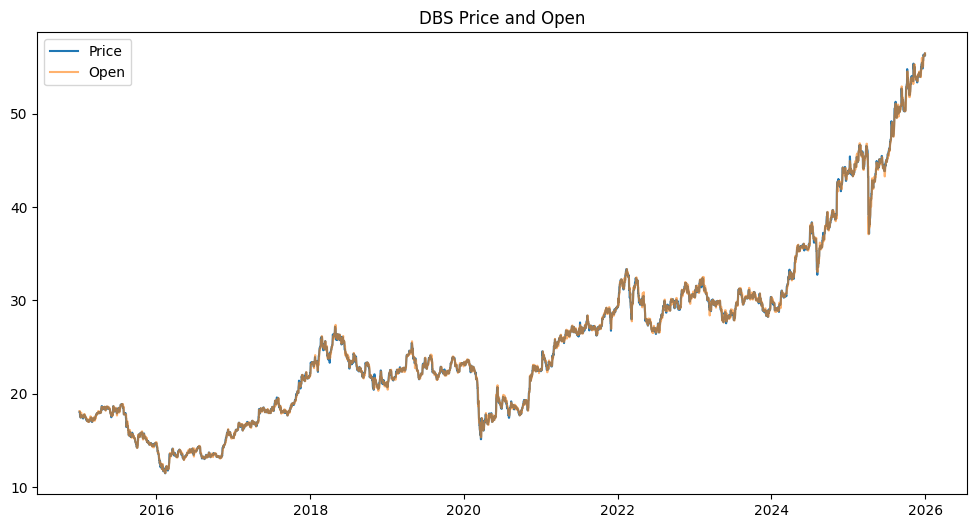

In [19]:
# Quick plots of selected features
plt.figure(figsize=(12,6))
plt.plot(df.index, df[target_col], label=target_col)
if 'Open' in df.columns:
	plt.plot(df.index, df['Open'], label='Open', alpha=0.6)
plt.title(f'DBS {target_col} and Open' if 'Open' in df.columns else f'DBS {target_col}')
plt.legend()
plt.show()

In [11]:
# prepare data for multivariate lstm
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# select features and scale (uses `features` selected above)
values = df[features].values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning with n_in timesteps
n_in = 10
reframed = series_to_supervised(scaled, n_in, 1)
# drop output columns for all vars except the chosen target
n_vars = len(features)
target_idx = features.index(target_col)
start_output = n_in * n_vars
drop_cols = [start_output + i for i in range(n_vars) if i != target_idx]
if drop_cols:
	reframed.drop(reframed.columns[drop_cols], axis=1, inplace=True)
print(reframed.head())

    var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var1(t-9)  var2(t-9)  \
10    0.211888    0.216833    0.199868    0.178737   0.201145   0.207848   
11    0.201145    0.207848    0.197958    0.175103   0.209275   0.213980   
12    0.209275    0.213980    0.195483    0.177194   0.212358   0.214542   
13    0.212358    0.214542    0.199734    0.178675   0.217557   0.219380   
14    0.217557    0.219380    0.202674    0.184197   0.215669   0.217891   

    var3(t-9)  var4(t-9)  var1(t-8)  var2(t-8)  ...  var4(t-3)  var1(t-2)  \
10   0.197958   0.175103   0.209275   0.213980  ...   0.184665   0.215514   
11   0.195483   0.177194   0.212358   0.214542  ...   0.182271   0.212201   
12   0.199734   0.178675   0.217557   0.219380  ...   0.179286   0.213462   
13   0.202674   0.184197   0.215669   0.217891  ...   0.182437   0.213913   
14   0.204100   0.184353   0.213781   0.216402  ...   0.182318   0.216099   

    var2(t-2)  var3(t-2)  var4(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  \
10   0.2

In [12]:
# split into train and test sets
data = reframed.values
test_split = 0.2
n_train = int((1 - test_split) * len(data))
train = data[:n_train, :]
test = data[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
print('train_X, train_y, test_X, test_y shapes:', train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X, train_y, test_X, test_y shapes: (1452, 10, 4) (1452,) (363, 10, 4) (363,)


Epoch 1/50


c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 - 2s - 72ms/step - loss: 0.0989 - val_loss: 0.0458
Epoch 2/50
23/23 - 0s - 8ms/step - loss: 0.0538 - val_loss: 0.0349
Epoch 3/50
23/23 - 0s - 7ms/step - loss: 0.0389 - val_loss: 0.0295
Epoch 4/50
23/23 - 0s - 7ms/step - loss: 0.0328 - val_loss: 0.0271
Epoch 5/50
23/23 - 0s - 10ms/step - loss: 0.0308 - val_loss: 0.0193
Epoch 6/50
23/23 - 0s - 8ms/step - loss: 0.0297 - val_loss: 0.0195
Epoch 7/50
23/23 - 0s - 7ms/step - loss: 0.0262 - val_loss: 0.0193
Epoch 8/50
23/23 - 0s - 6ms/step - loss: 0.0266 - val_loss: 0.0184
Epoch 9/50
23/23 - 0s - 6ms/step - loss: 0.0242 - val_loss: 0.0184
Epoch 10/50
23/23 - 0s - 7ms/step - loss: 0.0247 - val_loss: 0.0182
Epoch 11/50
23/23 - 0s - 7ms/step - loss: 0.0259 - val_loss: 0.0194
Epoch 12/50
23/23 - 0s - 7ms/step - loss: 0.0253 - val_loss: 0.0301
Epoch 13/50
23/23 - 0s - 7ms/step - loss: 0.0238 - val_loss: 0.0194
Epoch 14/50
23/23 - 0s - 7ms/step - loss: 0.0233 - val_loss: 0.0173
Epoch 15/50
23/23 - 0s - 7ms/step - loss: 0.0233 - val_loss: 0.021

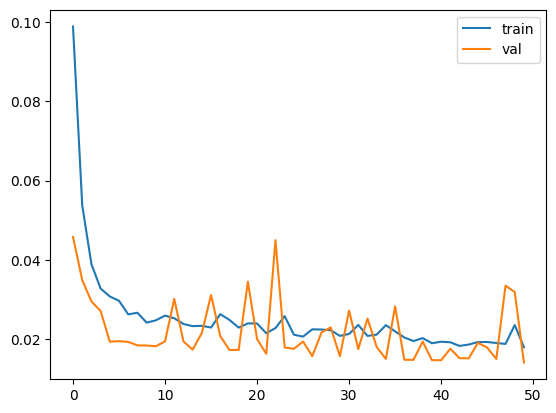

In [13]:
# design and train network
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [14]:
# make a prediction
yhat = model.predict(test_X)
# helper to invert scaling for target 'Close' using last timestep features
def invert_close(y_pred, X_window, scaler, features, target='Close'):
	n_vars = len(features)
	# take last timestep values
	X_last = X_window[:, -1, :]
	# build array for inverse_transform with same n_vars
	inv_full = np.zeros((len(y_pred), n_vars))
	for i in range(n_vars):
		if features[i] == target:
			inv_full[:, i] = y_pred.ravel()
		else:
			inv_full[:, i] = X_last[:, i]
	inv_rescaled = scaler.inverse_transform(inv_full)
	return inv_rescaled[:, features.index(target)]

inv_yhat = invert_close(yhat, test_X, scaler, features)
inv_y = invert_close(test_y.reshape(-1,1), test_X, scaler, features)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(f'Test RMSE: {rmse:.3f}')
# save model
try:
	model.save('dbs_lstm_karol_trained.h5')
	print('Saved model to dbs_lstm_karol_trained.h5')
except Exception as e:
	print('Could not save model:', e)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Test RMSE: 192.536
Saved model to dbs_lstm_karol_trained.h5
